## minimal TTV example

In [ ]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from jax import config
config.update('jax_enable_x64', True)

In [2]:
from jnkepler.jaxttv import JaxTTV

### 1. initialize JaxTTV class

In [3]:
# test data
d = pd.read_csv("kep51_transit_times.txt", sep="\s+", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])

# these are what we need
list_of_obs_transit_times = []
list_of_transit_time_errs = []
period_guess = [45.155305, 85.31646, 130.17809] # rough initial guess to track transit epochs

for j in range(3):
    list_of_obs_transit_times.append(np.array(d.tc[d.planum==j+1]))
    list_of_transit_time_errs.append(np.array(d.tcerr[d.planum==j+1]))

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8l/c_0pxd512sd6bbskytr1ccn80000gn/T/ipykernel_41015/3570350179.py:2: SyntaxWarning: invalid escape sequence '\s'
  d = pd.read_csv("kep51_transit_times.txt", sep="\s+", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])


In [4]:
t_start = 155.  # start of integration
t_end = 2950. # end of integration
dt = 1.0 # integration timestep

In [5]:
jttv = JaxTTV(t_start, t_end, dt, list_of_obs_transit_times, period_guess, errorobs=list_of_transit_time_errs)

# number of transiting planets:    3
# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)



### 2. parameter dict

In [6]:
# masses, and osculating orbital elements at t_start
par_dict = {
    "pmass": np.array([9.9e-6, 1.2e-5, 1.6e-5]), # planets' masses (solar mass)
    "period": np.array([45.154107, 85.314483, 130.1841370]),
    "ecosw": np.array([-1.72e-02, 1.89e-02, 1.17e-02]),
    "esinw": np.array([-4.07e-02, -3.48e-02, -2.81e-02]),
    "tic": np.array([159.1103, 295.3210, 212.0234]), # time of inferior conjunction
    ## default values when these parameters are not specified
    #"cosi": np.zeros(3),  # cosine of orbital inclination
    #"lnode": np.zeros(3), # longitude of ascending node
    #"smass": 1. # stellar mass
}

### 3. compute transit times

In [7]:
# this function returns only observed transit times and should be used for fitting
transit_times, fractional_energy_error = jttv.get_transit_times_obs(par_dict)

In [8]:
print("# observed")
print(jttv.tcobs_flatten)
print()
print("# model")
print(transit_times) 

# observed
[ 159.1102   204.26341  249.41429  294.57387  339.72659  384.87849
  430.03431  520.34296  565.50058  610.6575   655.81281  700.97563
  746.12681  791.28725  836.44031  881.59877  926.75401  971.9056
 1017.06093 1062.21173 1107.36679 1152.5208  1197.67694 1242.83033
 1287.98438 1333.14164 1378.29828 1423.45432 1468.61332 2462.03211
 2732.95267  295.31635  380.63913  465.95364  551.26314  636.56959
  892.51915  977.84155 1148.46496 1233.80861 1319.113   1489.75234
  212.02419  342.20768  472.39081  602.57368  862.93204  993.10486
 1123.28462 1253.45065 1383.63021 2555.20049 2945.7533 ]

# model
[ 159.11030184  204.26405044  249.41792158  294.57147206  339.72529064
  384.87921048  430.03409464  520.34446517  565.50086557  610.65759523
  655.8138862   700.97215266  746.12809161  791.28593663  836.44121503
  881.59740423  926.75150619  971.90556788 1017.0594238  1062.2126481
 1107.36653674 1152.52039557 1197.67489609 1242.82969269 1287.98510347
 1333.14121536 1378.29777595 1423.

In [9]:
# encouraged to check timing precision
_, _ = jttv.check_timing_precision(par_dict)

# fractional energy error (symplectic, dt=1.00e+00): 3.39e-09
# fractional energy error (symplectic, dt=4.52e-02): 7.07e-12
# max difference in tc: 6.01e-06 days (0.52 sec)


### plot

In [10]:
# list of *all* transit times between t_start and t_end; should NOT be used for fitting
tc_all_list = jttv.get_transit_times_all_list(par_dict)

/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:531: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


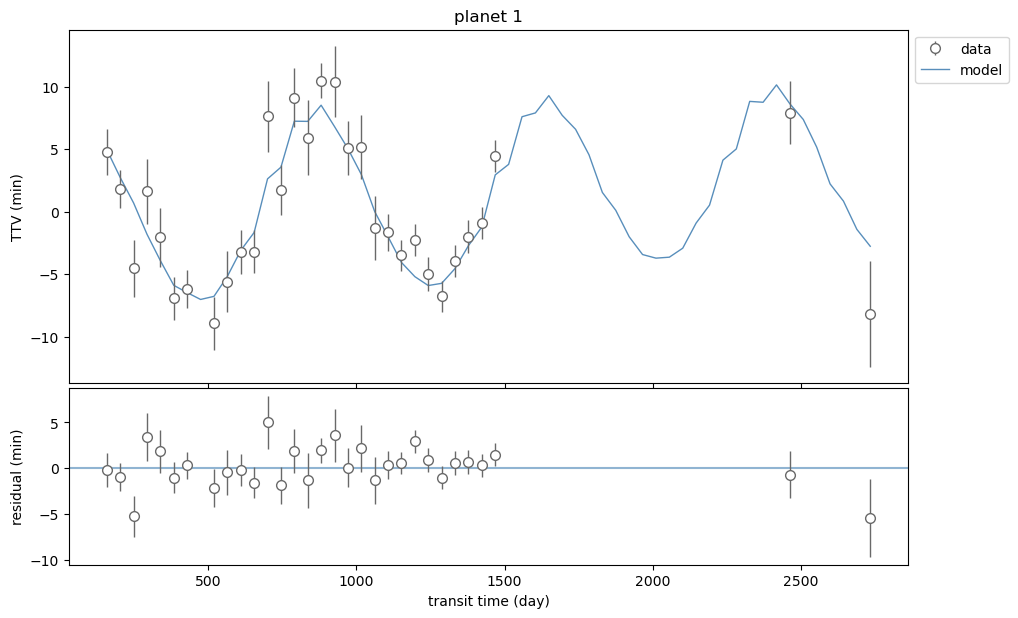

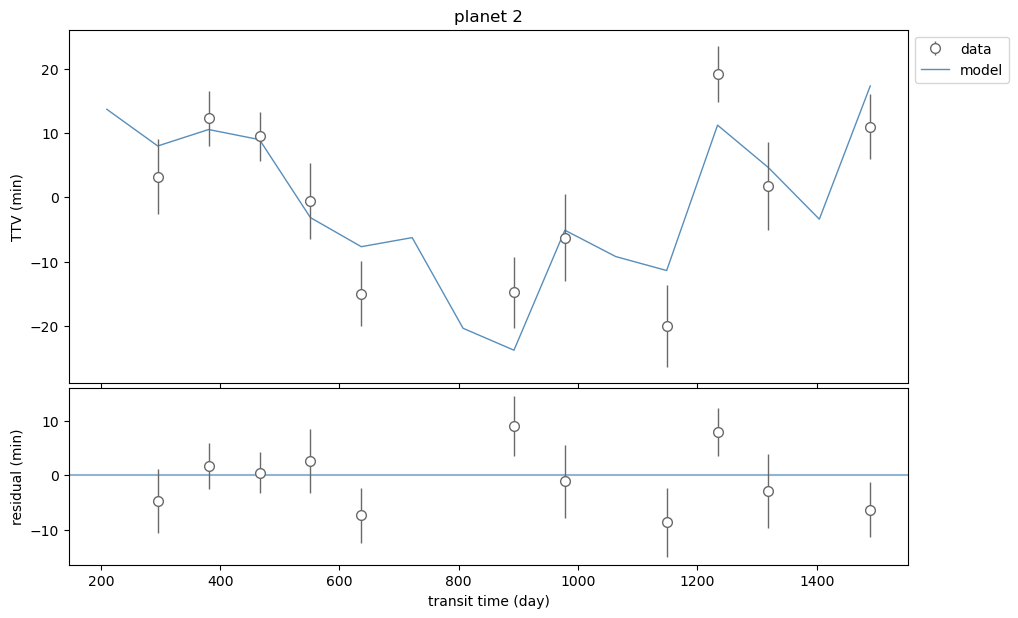

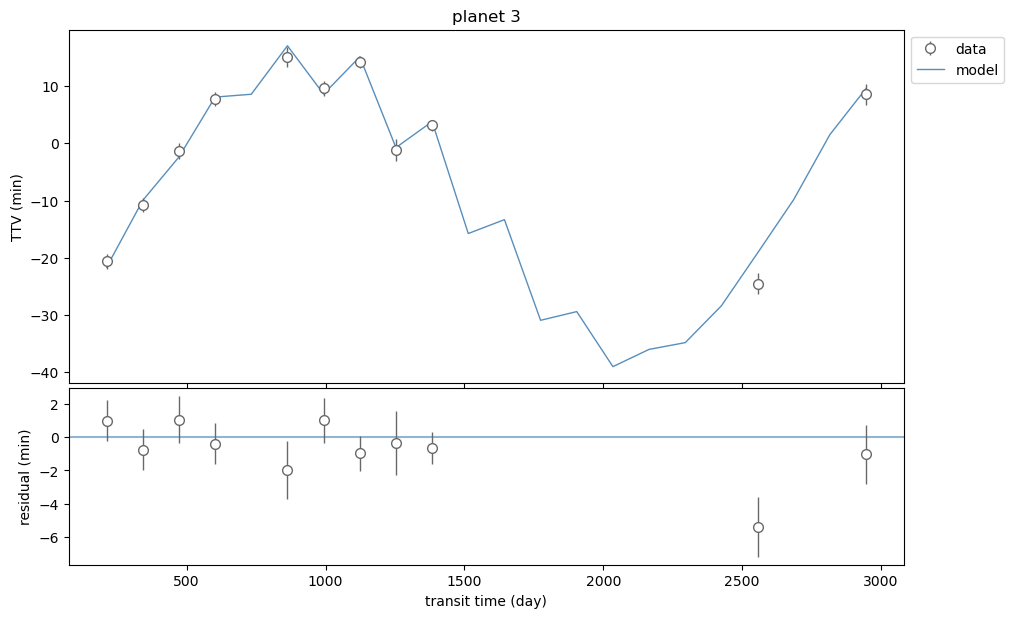

In [11]:
jttv.plot_model(tc_all_list)

### compute RVs as well

In [12]:
times_rv = np.linspace(500, 2500, 1000) # times at which RVs are evaluated
transit_times, rvs, fractional_energy_error = jttv.get_transit_times_and_rvs_obs(par_dict, times_rv)

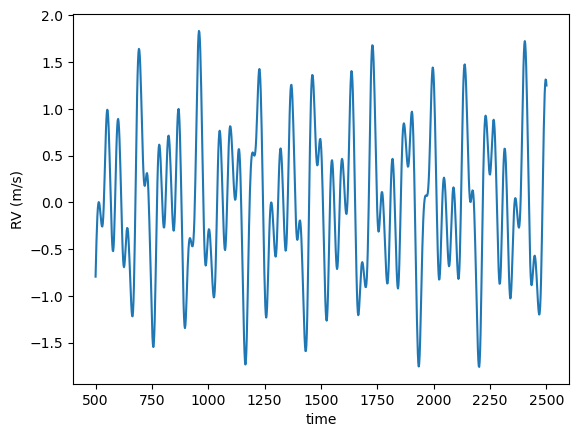

In [13]:
plt.xlabel("time")
plt.ylabel("RV (m/s)")
plt.plot(times_rv, rvs);

### adding non-transiting planet

Let's add a 4th non-transiting planet outside. 

In [ ]:
# define parameter dict including the non-transiting planet.
m4 = 3e-6
p4 = 260. 
ecosw4, esinw4 = 0., 0. 
tic4 = 200.

par_dict4 = {
    "pmass": np.array([9.9e-6, 1.2e-5, 1.6e-5, m4]),
    "period": np.array([45.154107, 85.314483, 130.1841370, p4]),
    "ecosw": np.array([-1.72e-02, 1.89e-02, 1.17e-02, ecosw4]),
    "esinw": np.array([-4.07e-02, -3.48e-02, -2.81e-02, esinw4]),
    "tic": np.array([159.1103, 295.3210, 212.0234, tic4]),
}

In [36]:
# define the indices of transiting planets, for which transit times are returned
# the innermost planet is zero
transit_orbit_idx = jnp.array([0, 1, 2])

In [37]:
# pass transit_orbit_idx to specify transiting planets
tc_all_list4 = jttv.get_transit_times_all_list(par_dict4, transit_orbit_idx=transit_orbit_idx)
#jttv.get_transit_times_obs(par_dict4, transit_orbit_idx=transit_idx) works in the same way

/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:531: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


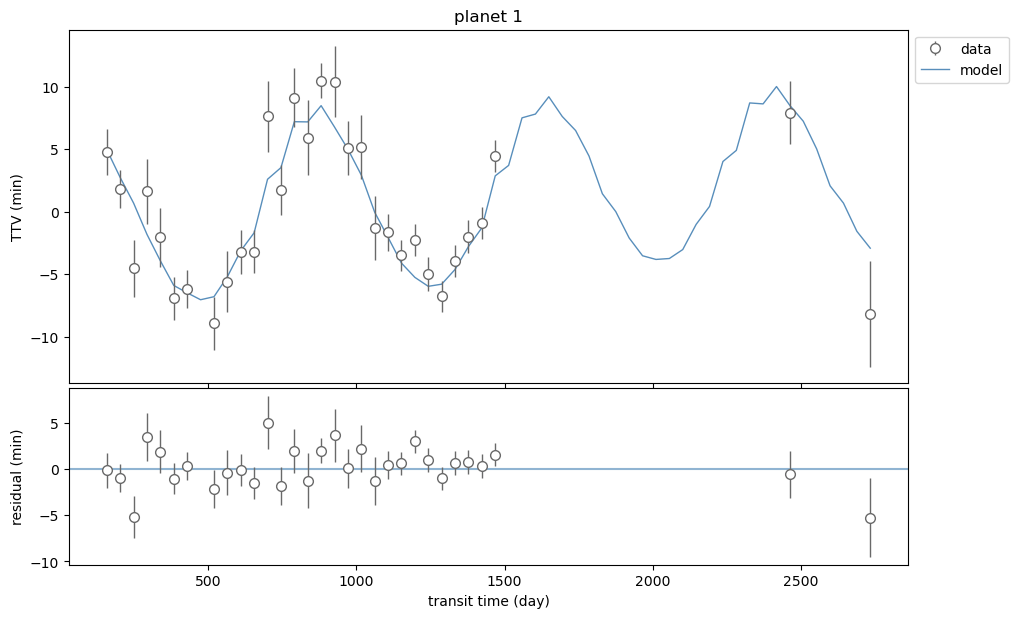

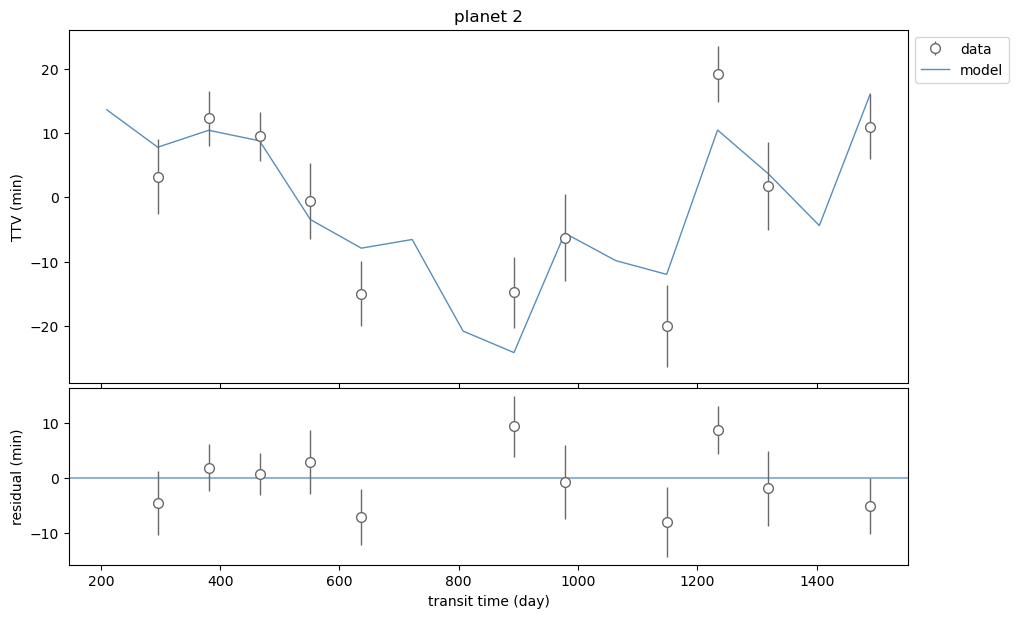

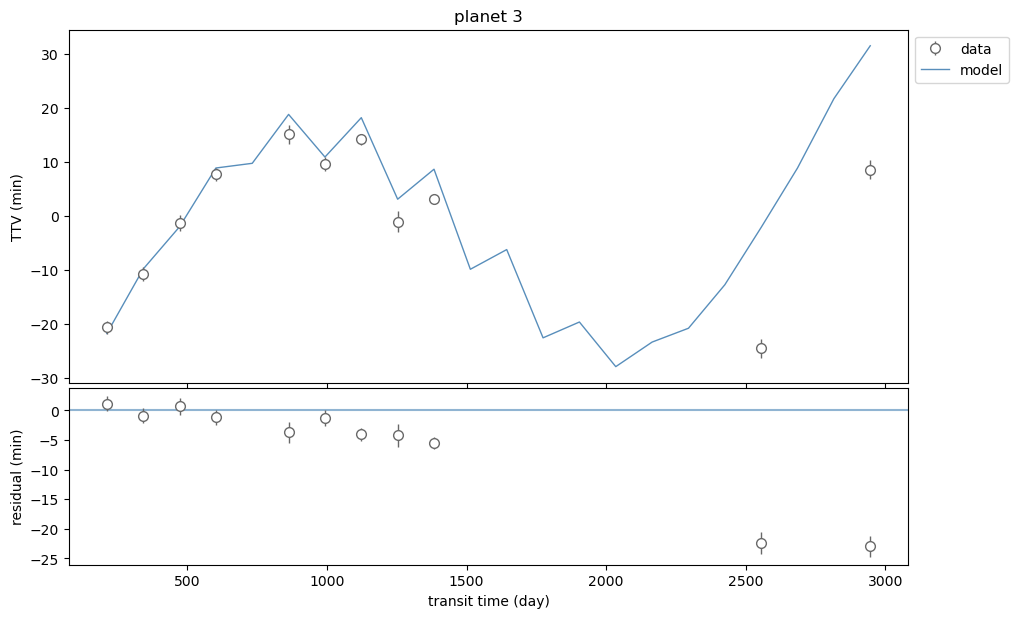

In [ ]:
# outermost planet's TTVs are now affected by the 4th planet
jttv.plot_model(tc_all_list4)